This notebook times a couple of ways of integrating a number of tanks in series

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Ntimes = 1000
Nstates = 20
t_end = 100
D = 2

In [3]:
import numpy

# No delays

## Normal way
Use a growing list for the history and an array for states

In [4]:
ts = numpy.linspace(0, t_end, Ntimes)
dt = ts[1]

In [5]:
Fin = 2
k = 1
A = 1

In [6]:
%%time
statehistory = []
states = numpy.ones(Nstates)
for i, t in enumerate(ts):
    Fout = states[0]*k
    dsdt = [1/A*(Fin - Fout)]
    for j in range(1, Nstates):
        Fin_j = k*states[j - 1]
        Fout_j = k*states[j]
        dsdt.append(1/A*(Fin_j - Fout_j))
    
    states += numpy.array(dsdt)*dt
    
    # we have to copy because the above += is in place.
    statehistory.append(states.copy())

Wall time: 32 ms


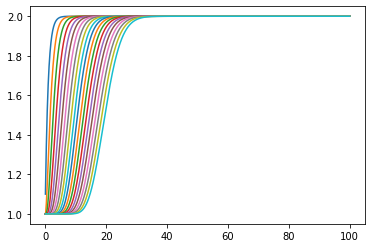

In [7]:
plt.plot(ts, statehistory);

## Preallocation
If you are used to Matlab you may imagine pre-allocating statehistory would save lots of time


In [8]:
%%time
statehistory = numpy.empty((Ntimes, Nstates))
states = numpy.ones(Nstates)
for i, t in enumerate(ts):
    Fout = states[0]*k
    dsdt = [1/A*(Fin - Fout)]
    for j in range(1, Nstates):
        Fin_j = k*states[j - 1]
        Fout_j = k*states[j]
        dsdt.append(1/A*(Fin_j - Fout_j))
    
    states += numpy.array(dsdt)*dt
    
    statehistory[i, :] = states

Wall time: 32 ms


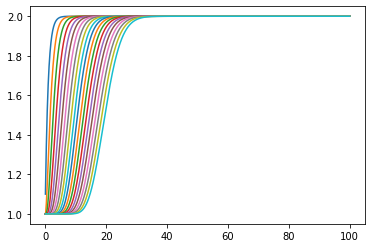

In [9]:
plt.plot(ts, statehistory);

Same result, much the same amount of time.

# Dead time

Now, let's introduce a delay between each tank.

## Lists and interp

In [10]:
%%time
statehistory = [[] for _ in states]
states = numpy.ones(Nstates)
for i, t in enumerate(ts):
    Fout = states[0]*k
    dsdt = [1/A*(Fin - Fout)]
    for j in range(1, Nstates):
        delayed_Fin_j = k*(numpy.interp(t - D, ts[:i], statehistory[j-1]) if t > 0 else states[j-1])
        Fout_j = k*states[j]
        dsdt.append(1/A*(delayed_Fin_j - Fout_j))
    
    states += numpy.array(dsdt)*dt
    
    for j, s in enumerate(states):
        statehistory[j].append(s)

Wall time: 639 ms


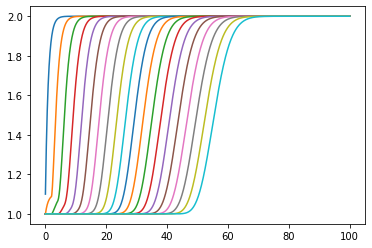

In [11]:
plt.plot(ts, numpy.array(statehistory).T);

OK, that took a lot longer.

## Approximate indexing
What if we just use indexing instead of interpolation?

In [12]:
%%time
statehistory = [[] for _ in states]
states = numpy.ones(Nstates)
for i, t in enumerate(ts):
    Fout = states[0]*k
    dsdt = [1/A*(Fin - Fout)]
    for j in range(1, Nstates):
        delayed_Fin_j = k*(statehistory[j-1][i - int(D/dt)] if t > D else states[j-1])
        Fout_j = k*states[j]
        dsdt.append(1/A*(delayed_Fin_j - Fout_j))
    
    states += numpy.array(dsdt)*dt
    
    for j, s in enumerate(states):
        statehistory[j].append(s)

Wall time: 49 ms


OK, we're back to almost the same time as before, but do we get the same result?

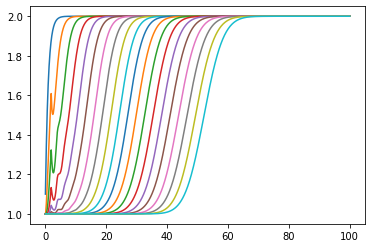

In [13]:
plt.plot(ts, numpy.array(statehistory).T);

No. the rounding errors build up. If we use this strategy we had better choose a step size which divides cleanly into the dead time.